# Photo-z with torch implementation of ViT

In [1]:
import torch
from vit_pytorch import ViT
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets, transforms
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-4
gamma = 0.7
seed = 42

### Jobs on jupyter 

In [3]:
%%bash
squeue -u vbrekke

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


In [4]:
# Cluster ID taken from job ID above
job_id = 6419922
cluster_id = 'perlmutter_{}'.format(job_id)

In [5]:
import ipyparallel as ipp
# Use default profile
c = ipp.Client(timeout=60, cluster_id=cluster_id)
print('Worker IDs:', c.ids)

ModuleNotFoundError: No module named 'ipyparallel'

### Data

In [3]:
data = np.load('/global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp/download')

In [4]:
img = np.load('data/img_20k.npy')
z = np.load('data/z_20k.npy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


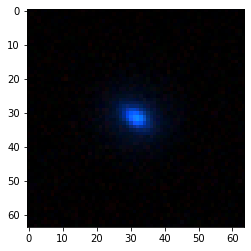

In [5]:
#check what raw images look like
plt.imshow(img[0, ..., 0:3]);

In [6]:
img.dtype

dtype('float32')

In [7]:
# Scaling the images
from scipy.stats import median_abs_deviation

scaling = []
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
    sigma = 1.4826*median_abs_deviation(img[...,i].flatten())
    scaling.append(sigma)
    
def preprocessing(image):
    return np.arcsinh(img / scaling / 3. )

img = preprocessing(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


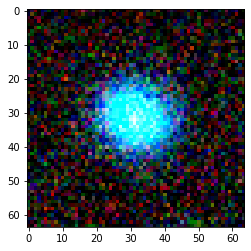

In [8]:
# Check transformed images
plt.imshow(img[0, ..., :3]);

Shapes of images in torch need to be organised differently

In [9]:
img.shape

(20000, 64, 64, 5)

In [10]:
#img_reshape = np.reshape(img_transformed, [-1, 5, 64, 64])

img = torch.transpose(torch.transpose(torch.tensor(img), 2,3), 1, 2)

In [11]:
img.shape

torch.Size([20000, 5, 64, 64])

### Loader without Dataset

In [12]:
# Converting train and validation image data into tensors
train_X_tensor = img[:10000].to(torch.float32)
val_X_tensor = img[10000:].to(torch.float32)

# Converting train and validation labels into tensors
train_y_tensor = torch.tensor(z[:10000]).to(torch.float32)
val_y_tensor = torch.tensor(z[10000:]).to(torch.float32)

# Creating train and validation tensors
train_tensor = TensorDataset(train_X_tensor, train_y_tensor)
val_tensor = TensorDataset(val_X_tensor, val_y_tensor)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


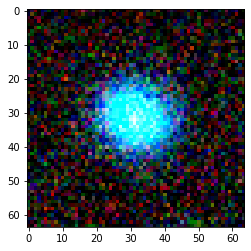

In [13]:
plt.imshow(torch.transpose(torch.transpose(train_X_tensor, 1,2), 2,3)[0,...,:3])

In [14]:
batch_size = 64
train_loader = DataLoader(dataset = train_tensor, batch_size=batch_size)
val_loader = DataLoader(dataset = val_tensor, batch_size=batch_size)

  0%|          | 0/157 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


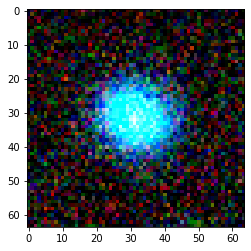

In [15]:
# Check Dataset images
for data, label in tqdm(train_loader):
    plt.imshow(torch.transpose(torch.transpose(data, 1,2), 2,3)[0,...,:3])

    break
#plt.imshow(np.reshape(img_reshape, [-1, 64, 64, 5])[0, ..., :3])

### Model

In [16]:
model = ViT(
    dim=256,
    image_size=64,
    patch_size=16,
    num_classes=1,
    depth=6,
    heads=16,
    mlp_dim=512,
    channels=5,
    pool='mean')

### Training

In [17]:
# loss function
criterion = nn.MSELoss()
# optimizer
lr = 3e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [18]:
from torch.utils.tensorboard import SummaryWriter
writer_train = SummaryWriter('logs/ViT_2/train')
writer_val = SummaryWriter('logs/ViT_2/validation')

In [19]:
epochs = 20
losses = {'train':[],
          'val':[]}

for epoch in range(epochs):
    epoch_loss = 0
    i = 0
    for data, label in tqdm(train_loader):
        i+=1
        model.train()
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, label)

        #optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss / len(train_loader)
        #if i%100==0:
        #    writer_train.add_scalar('epoch_loss', loss, epoch * len(train_loader) + i )
        
    with torch.no_grad():
        model.eval()
        epoch_val_loss = 0
        i = 0 
        for data, label in val_loader:
    
            val_output = model(data).squeeze()

            val_loss = criterion(val_output, label)

            epoch_val_loss += val_loss / len(val_loader)
            
            #if i%100==0:
             #   writer_val.add_scalar('epoch_loss', val_loss, epoch * len(val_loader) + i )
    
    scheduler.step()

    losses['train'].append(epoch_loss.detach()), losses['val'].append(epoch_val_loss.detach())
    print(f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - val_loss : {epoch_val_loss:.4f}\n")
    
    writer_train.add_scalar('epoch_loss', epoch_loss, epoch)
    writer_val.add_scalar('epoch_loss', epoch_val_loss, epoch)
        


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.3203 - val_loss : 0.0097



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0095 - val_loss : 0.0090



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0088 - val_loss : 0.0083



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0082 - val_loss : 0.0077



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0076 - val_loss : 0.0070



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.0068 - val_loss : 0.0063



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.0060 - val_loss : 0.0054



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.0052 - val_loss : 0.0047



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.0045 - val_loss : 0.0042



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.0040 - val_loss : 0.0038



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.0037 - val_loss : 0.0036



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.0035 - val_loss : 0.0034



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.0033 - val_loss : 0.0033



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.0032 - val_loss : 0.0032



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.0032 - val_loss : 0.0032



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.0031 - val_loss : 0.0031



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.0031 - val_loss : 0.0031



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.0031 - val_loss : 0.0031



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.0030 - val_loss : 0.0031



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.0030 - val_loss : 0.0030



In [20]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'\n Number of parameters: {count_parameters(model)}')


 Number of parameters: 8212993


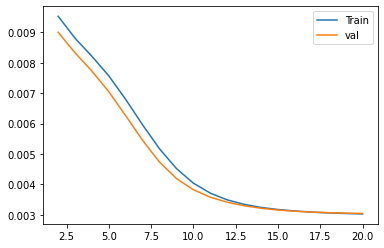

In [21]:
epoch = np.arange(2, epochs+1)
plt.plot(epoch, losses['train'][1:], label='Train')
plt.plot(epoch, losses['val'][1:], label='val')
plt.legend();

In [22]:
# Get the prediction
preds = model(val_X_tensor)

In [23]:
preds.detach().numpy()

array([[0.272514  ],
       [0.3552679 ],
       [0.08552362],
       ...,
       [0.17463438],
       [0.21743473],
       [0.36157027]], dtype=float32)

In [24]:
np.mean((preds.detach().numpy() - z[10000:])**2)

0.019596985

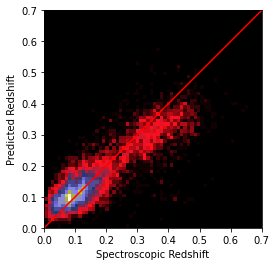

In [25]:
import matplotlib.pyplot as plt
plt.hist2d(z[10000:], preds.detach().numpy().squeeze(), 64, range=[[0,0.7],[0,0.7]], cmap='gist_stern'); 
plt.gca().set_aspect('equal');
plt.plot([0,0.7],[0,0.7],color='r')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Predicted Redshift');

In [26]:
from function_lib import *
dz, pred_bias, smad, out_frac = metrics(z[10000:], preds.detach().numpy().squeeze())
print_metrics(pred_bias, smad, out_frac)

Prediction bias: 0.0021


<IPython.core.display.Latex object>

Outlier fraction: 22.56%


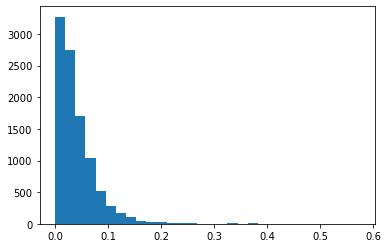

In [27]:
plt.hist(np.abs(z[10000:] - preds.detach().numpy().squeeze()), bins=30);

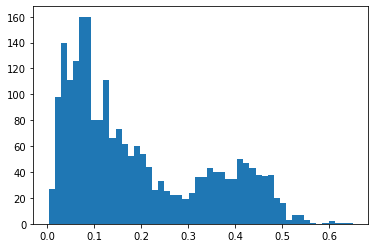

In [29]:
outliers = np.abs(dz) > 0.05
plt.hist(z[10000:][outliers], bins=50);

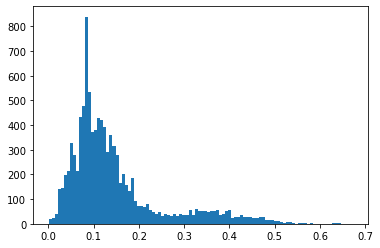

In [30]:
plt.hist(z[:10000], bins=100);

### Torchvision models

In [ ]:
from torchvision.models import vit_b_16

In [ ]:
model_pretrained = vit_b_16(weights='DEFAULT')

In [ ]:
model_pretrained.heads.head = nn.Linear(in_features=768, out_features=1, bias=True)

In [ ]:
print(model_pretrained)

### Reshape from 64 to 250

In [ ]:
img.shape

In [ ]:
import torch.nn.functional as F

img_interpolate = F.interpolate(img, size=224)  #The resize operation on tensor.

In [ ]:
img_interpolate.shape

In [ ]:
plt.imshow(torch.transpose(torch.transpose(img_interpolate, 1,2), 2,3)[0,...,:3])

In [ ]:
# Converting train and validation image data into tensors
train_X_tensor = img[:10000].to(torch.float32)
val_X_tensor = img[10000:].to(torch.float32)

# Converting train and validation labels into tensors
train_y_tensor = torch.tensor(z[:10000].values).to(torch.float32)
val_y_tensor = torch.tensor(z[10000:].values).to(torch.float32)

# Creating train and validation tensors
train_tensor = TensorDataset(train_X_tensor, train_y_tensor)
val_tensor = TensorDataset(val_X_tensor, val_y_tensor)

In [ ]:
# Creating train and validation tensors
train_tensor = TensorDataset(img_interpolate[:10000, :3].to(torch.float32), train_y_tensor)
val_tensor = TensorDataset(img_interpolate[10000:, :3].to(torch.float32), val_y_tensor)

In [ ]:
batch_size = 64
train_loader = DataLoader(dataset = train_tensor, batch_size=batch_size)
val_loader = DataLoader(dataset = val_tensor, batch_size=batch_size)

In [ ]:
epochs = 5
for epoch in range(epochs):
    epoch_loss = 0

    for data, label in tqdm(train_loader):
        model_pretrained.train()
        optimizer.zero_grad()
        print(data.shape)
        output = model_pretrained(data).squeeze()
        loss = criterion(output, label)

        #optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        model_pretrained.eval()
        epoch_val_loss = 0
        for data, label in val_loader:
    
            val_output = model_pretrained(data).squeeze()

            val_loss = criterion(val_output, label)

            epoch_val_loss += val_loss / len(val_loader)
    
    scheduler.step()
    
    print(f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - val_loss : {epoch_val_loss:.4f}\n")

In [ ]:
epoch_loss

In [31]:
#KERNEL DIES SYSTEMATICALLY